In [1]:
import os
import json
import gzip
import time
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

In [2]:
DATA_PATH = '../data/phone_data.json.gz'
RANDOM_SEED = 0

In [3]:
%matplotlib inline

In [4]:
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # tf 2.0+
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Load data

In [5]:
def gzip2json(path):
    with gzip.GzipFile(path, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
    return data

In [6]:
data = gzip2json(DATA_PATH)

* chr(769) we are replacing stress near letters

TODO: think about removing dash '-' as it has no phoneme at all

In [7]:
# ignore stress and x^y phonemes

words, letters, phones = [], [], []
ignored = 0

for item in tqdm(data):
    word = item['word'].lower()
    
    phns = []
    for phone in item['phones']:
        if chr(769) in phone:
            phone = phone.replace(chr(769), '')
        if chr(94) in phone:
            phone = phone[1]
        phns += [phone]

    ltrs = [letter for letter in word]
        
    if set(['#', "{и^е}'", "{о^у}'", "о'", "ґ'"]).intersection(phns):
        ignored += 1
        continue
    words.append(word)
    letters.append(ltrs)
    phones.append(phns)

data_preprocessed = list(zip(words, letters, phones))

100%|██████████| 160385/160385 [00:02<00:00, 78040.01it/s]


In [8]:
data_preprocessed = list(zip(words, letters, phones))

In [9]:
sample = random.choice(data_preprocessed)
print(f'word: ', sample[0])
print(f'letters: ', sample[1])
print(f'phonemes: ', sample[2])

word:  перепрофільований
letters:  ['п', 'е', 'р', 'е', 'п', 'р', 'о', 'ф', 'і', 'л', 'ь', 'о', 'в', 'а', 'н', 'и', 'й']
phonemes:  ['п', 'е', 'р', 'е', 'п', 'р', 'о', "ф'", 'і', "л'", 'о', 'в', 'а', 'н', 'и', 'й']


### Preprocess

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

In [12]:
class SequenceTokenizer:
    
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.oov_token ='<UNK>'
        self.oov_token_index = 0
        
    def fit(self, sequence):
        self.index2word = dict(enumerate([self.oov_token] + sorted(set(flatten(sequence))), 1))
        self.word2index = {v:k for k,v in self.index2word.items()}
        self.oov_token_index = self.word2index.get(self.oov_token)
        return self
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.word2index.get(item, self.oov_token_index) for item in line])
        return res

In [13]:
def pad_sequence(x, max_len=None):
    return tf.keras.preprocessing.sequence.pad_sequences(x, 
                                                         padding='post',
                                                         maxlen=max_len)

In [14]:
def add_sep_tokens(x):
    return ['<start>'] + x + ['<end>']

In [15]:
input_sequences = list(map(add_sep_tokens, letters))
target_sequences = list(map(add_sep_tokens, phones))

In [16]:
max_len_encoder = max(map(lambda x: len(x), input_sequences))
max_len_decoder = max(map(lambda x: len(x), target_sequences))
print(max_len_encoder, max_len_decoder)

36 33


In [17]:
tokenizer_encode = SequenceTokenizer().fit(input_sequences)
tokenizer_decode = SequenceTokenizer().fit(target_sequences)

In [18]:
X_token = tokenizer_encode.transform(input_sequences)
y_token = tokenizer_decode.transform(target_sequences)

In [19]:
X_padded = pad_sequence(X_token, max_len_encoder)
y_padded = pad_sequence(y_token, max_len_decoder)

X_padded.shape, y_padded.shape

((160314, 36), (160314, 33))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.05, random_state=RANDOM_SEED)

In [21]:
X_train.shape, y_train.shape

((152298, 36), (152298, 33))

In [22]:
# for final validation, with the same seed to make sure that split is the same

input_train, input_test, output_train, output_test = train_test_split(
    letters, phones, test_size=0.05, random_state=RANDOM_SEED
)

### Seq2seq with Attention

#### tensor data and params

In [23]:
BUFFER_SIZE = X_train.shape[0]
BUFFER_SIZE_VAL = X_test.shape[0]
BATCH_SIZE = 128

steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
steps_per_epoch_val = BUFFER_SIZE_VAL // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_size_encode = len(tokenizer_encode.word2index) + 1
vocab_size_decode = len(tokenizer_decode.word2index) + 1

In [24]:
max_length_input, max_length_output = X_train.shape[1], y_train.shape[1]

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [27]:
example_input_batch, example_output_batch = next(iter(train_dataset))
example_input_batch.shape, example_output_batch.shape

(TensorShape([128, 36]), TensorShape([128, 33]))

#### define model

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [29]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [31]:
encoder = Encoder(vocab_size_encode, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 36, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [32]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 36, 1)


In [33]:
decoder = Decoder(vocab_size_decode, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 92)


#### define optimizer and loss

In [34]:
optimizer = tf.keras.optimizers.Adam()

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### train the model

In [36]:
@tf.function
def train_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer_decode.word2index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [37]:
@tf.function
def val_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer_decode.word2index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    return batch_loss

In [38]:
checkpoint_dir = '../tf_checkpoints/simple_phones'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [39]:
n_epochs = 20
history = {}

for epoch in range(1, n_epochs+1):
    start_time = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
        batch_loss = val_step(inp, targ, enc_hidden)
        total_val_loss += batch_loss
    
    print('loss: {loss:.4f}\tval_loss: {val_loss:.4f}\texec_time: {exec_time:.2f} seconds\n'.format(
            loss = total_loss / steps_per_epoch, 
            val_loss = total_val_loss / steps_per_epoch_val,
            exec_time = time.time() - start_time))
    
    history['train'] = history.get('train', []) + [total_loss.numpy() / steps_per_epoch]
    history['val'] = history.get('val', []) + [total_val_loss.numpy() / steps_per_epoch_val]
            
#     saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1/20
loss: 0.1888	val_loss: 0.0059	exec_time: 264.64 seconds

Epoch 2/20
loss: 0.0109	val_loss: 0.0041	exec_time: 213.50 seconds

Epoch 3/20
loss: 0.0158	val_loss: 0.0043	exec_time: 213.43 seconds

Epoch 4/20
loss: 0.0033	val_loss: 0.0021	exec_time: 213.46 seconds

Epoch 5/20
loss: 0.0045	val_loss: 0.0029	exec_time: 213.46 seconds

Epoch 6/20
loss: 0.0064	val_loss: 0.0173	exec_time: 213.36 seconds

Epoch 7/20
loss: 0.0046	val_loss: 0.0037	exec_time: 213.38 seconds

Epoch 8/20
loss: 0.0054	val_loss: 0.0035	exec_time: 213.37 seconds

Epoch 9/20
loss: 0.0040	val_loss: 0.0051	exec_time: 213.44 seconds

Epoch 10/20
loss: 0.0028	val_loss: 0.0035	exec_time: 213.52 seconds

Epoch 11/20
loss: 0.0059	val_loss: 0.0106	exec_time: 213.48 seconds

Epoch 12/20
loss: 0.0063	val_loss: 0.0024	exec_time: 213.43 seconds

Epoch 13/20
loss: 0.0056	val_loss: 0.0049	exec_time: 213.38 seconds

Epoch 14/20
loss: 0.0097	val_loss: 0.0034	exec_time: 213.29 seconds

Epoch 15/20
loss: 0.0033	val_loss: 0.0039	e

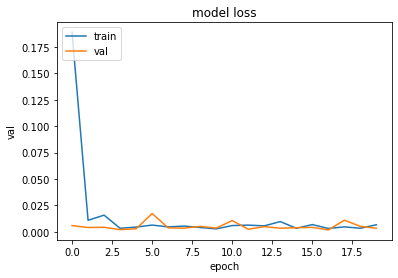

In [40]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
# restoring 17 epoch
checkpoint.restore(os.path.join(checkpoint_dir, "ckpt") + '-17')

#### validate the results

In [45]:
def evaluate(word):
    
    ltrs = add_sep_tokens([letter for letter in word])
    
    attention_plot = np.zeros((max_length_output, max_length_input))

    inputs = tokenizer_encode.transform([ltrs])
    inputs = pad_sequence(inputs, max_len=max_len_encoder)
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_decode.word2index['<start>']], 0)

    for t in range(max_length_output):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer_decode.index2word[predicted_id] + ' '

        if tokenizer_decode.index2word[predicted_id] == '<end>':
            return result, " ".join(ltrs), attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, " ".join(ltrs), attention_plot

In [46]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def paraphrase(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted paraphrase: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [47]:
evaluate('аахен')[0].replace('<end>', '').strip()

'а а х е н'

In [48]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Input: <start> ч о л о в і к <end>
Predicted paraphrase: ч о л о в' і к <end> 


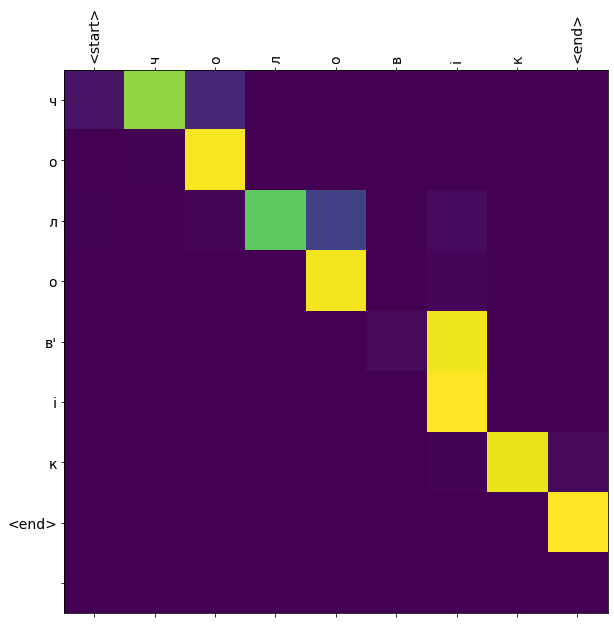

In [49]:
paraphrase('чоловік')

Input: <start> а в т е н т и ч н и й <end>
Predicted paraphrase: а ў т е н т и ч н и й <end> 


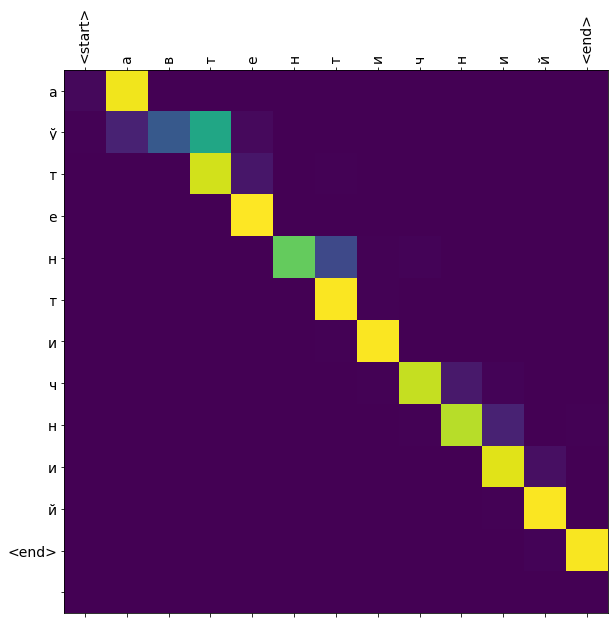

In [50]:
paraphrase('автентичний')

In [51]:
correct_pred = 0
incorrect_pred = []
total_num = len(input_test)

for sample, target in tqdm(zip(input_test, output_test)):
    prediction = evaluate(sample)[0].replace('<end>', '').strip()
    target = " ".join(target)
    if prediction == target:
        correct_pred += 1
    else:
        incorrect_pred.append((sample, target, prediction))

8016it [13:11, 10.13it/s]


In [52]:
print(f'correct prediction acc: {correct_pred/total_num:.2f}')

correct prediction acc: 0.99


In [53]:
len(incorrect_pred)

98

#### prepare data for kaldi

In [64]:
with open('lexicon_prep.txt') as file_:
    words = file_.readlines()
words = [word.strip() for word in words]

In [69]:
words[:100]

['позабризкувала',
 'виховання',
 'затишшя',
 'задихавшись',
 'одинокий',
 'знакомих',
 'жалюгідна',
 'легкої',
 'вмілі',
 'наїдуть',
 'озвалась',
 'спира',
 'груні',
 'зручніше',
 'двохсот',
 'ковдри',
 'нагріти',
 'виколупай',
 'потопили',
 'відчалила',
 'заробітком',
 'покривдила',
 'рішайся',
 'женити',
 'одкласти',
 'випадковості',
 'вчинити',
 'променем',
 'річ',
 'вшкварне',
 'отцу',
 'викликану',
 'готувалися',
 'володар',
 'гірську',
 'чотирма',
 'грамотніша',
 'случчю',
 'перелякалась',
 'учень',
 'підточує',
 'повибивали',
 'зупинила',
 'звалися',
 'стрий',
 'переяславський',
 'уставив',
 'однімав',
 'злодійкуватими',
 'орищиного',
 'гостю',
 'хворим',
 'найніжніших',
 'верховодити',
 'неозорими',
 'наклонити',
 'обробляє',
 'портрет',
 'престолу',
 'царина',
 'вибором',
 'гнулися',
 'непохибності',
 'зачата',
 'видалась',
 'лайок',
 'стоптані',
 'залишки',
 'бієвські',
 'упораєшся',
 'медведям',
 'особливих',
 'сажень',
 'перейду',
 'розщебечеться',
 'сміливців',
 'бритва',

In [85]:
res = []

for word in tqdm(words):
    phn = evaluate(word)[0].replace('<end>', '').strip()
    if len(phn.split()) - len(word) > 3:
        phn = phn[:2*len(word)]
    res.append((word, phn))

100%|██████████| 72517/72517 [1:38:36<00:00, 12.26it/s]


In [86]:
res[:100]

[('позабризкувала', 'п о з а б р и з к у в а л а'),
 ('виховання', "в и х о в а н': а"),
 ('затишшя', "з а т и ш': а"),
 ('задихавшись', "з а д и х а ў ш и с' к"),
 ('одинокий', 'о д и н о к и й'),
 ('знакомих', 'з н а к о м и х'),
 ('жалюгідна', "ж а л' у г' і д н а"),
 ('легкої', 'л е х к о й і'),
 ('вмілі', "ў м' і л' і"),
 ('наїдуть', "н а й і д у т'"),
 ('озвалась', "о з в а л а с'"),
 ('спира', 'с п и р а'),
 ('груні', "г р у н' і"),
 ('зручніше', "з р у ч н' і ш е"),
 ('двохсот', 'д в о х с о т'),
 ('ковдри', 'к о ў д р и'),
 ('нагріти', "н а г р' і т и"),
 ('виколупай', 'в и к о л у п а й'),
 ('потопили', 'п о т о п и л и'),
 ('відчалила', "в' і {дж} ч а л и л а"),
 ('заробітком', "з а р о б' і т к о м"),
 ('покривдила', 'п о к р и ў д и л а'),
 ('рішайся', "р' і ш а й с' а"),
 ('женити', 'ж е н и т и'),
 ('одкласти', 'о д к л а с т и'),
 ('випадковості', "в и п а д к о в о с' т' і"),
 ('вчинити', 'ў ч и н и т и'),
 ('променем', 'п р о м е н е м'),
 ('річ', "р' і ч"),
 ('вшквар

In [87]:
with open('lexicon_prep_out.txt', 'w') as file_:
    for k, v in tqdm(res):
        file_.write(k + " " + v + "\n")

100%|██████████| 72517/72517 [00:00<00:00, 643696.84it/s]
